# Import des Bibliothèques et Chargement des Données
Importation des bibliothèques nécessaires (pandas, numpy, sklearn, matplotlib, shap, lime, etc.) et chargement des données des statistiques d'équipes et des résultats de matchs.

In [2]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
import shap
import xgboost as xgb

train_home_team_statistics_df = pd.read_csv('./data/Train_data/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./data/Train_data/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv("./data/Y_train.csv", index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})

train_new_y_h_wins = train_scores['HOME_WINS']
train_new_y_a_wins = train_scores['AWAY_WINS']
train_new_y_draw = train_scores['DRAW']

X_train_away, X_test_away, y_train_away, y_test_away = model_selection.train_test_split(train_data, train_new_y_a_wins, train_size=0.8, random_state=42)
X_train_away, X_valid_away, y_train_away, y_valid_away = model_selection.train_test_split(X_train_away, y_train_away, train_size=0.8, random_state=42)

X_train_home, X_test_home, y_train_home, y_test_home = model_selection.train_test_split(train_data, train_new_y_h_wins, train_size=0.8, random_state=42)
X_train_home, X_valid_home, y_train_home, y_valid_home = model_selection.train_test_split(X_train_home, y_train_home, train_size=0.8, random_state=42)

X_train_draw, X_test_draw, y_train_draw, y_test_draw = model_selection.train_test_split(train_data, train_new_y_draw, train_size=0.8, random_state=42)
X_train_draw, X_valid_draw, y_train_draw, y_valid_draw = model_selection.train_test_split(X_train_draw, y_train_draw, train_size=0.8, random_state=42)



# Construction de Modèles Interprétables
Développement et évaluation de modèles inheremment interprétables comme la régression logistique, les arbres de décision et les règles de décision.

[0]	train-mlogloss:0.99416	valid-mlogloss:1.04143


/Users/leo/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[143]	train-mlogloss:0.00986	valid-mlogloss:0.68734


/var/folders/jf/w93xdj8s18x_5shj9j_778mh0000gn/T/ipykernel_358/1001204639.py:26: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x800 with 0 Axes>

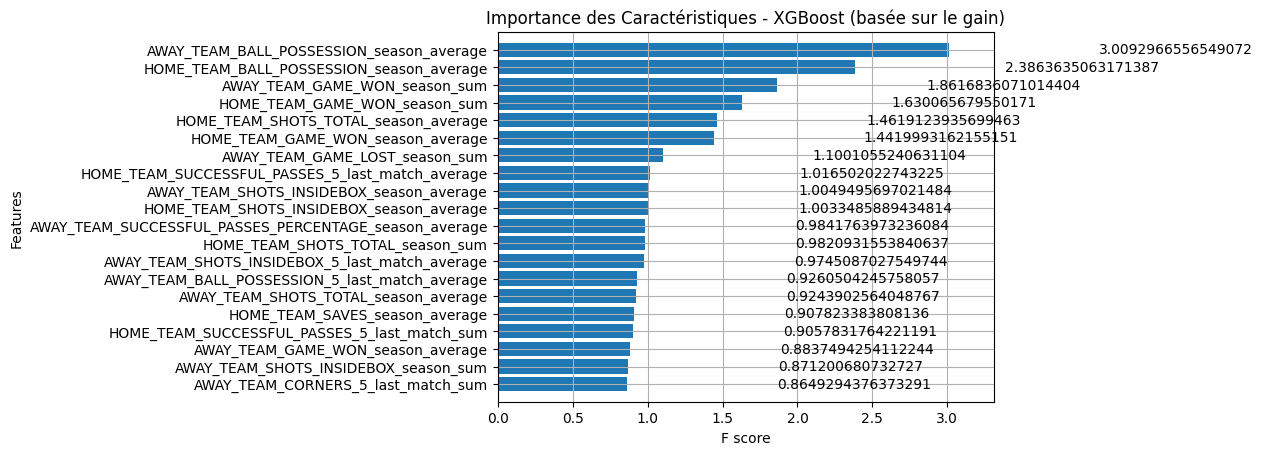

<Figure size 1200x800 with 0 Axes>

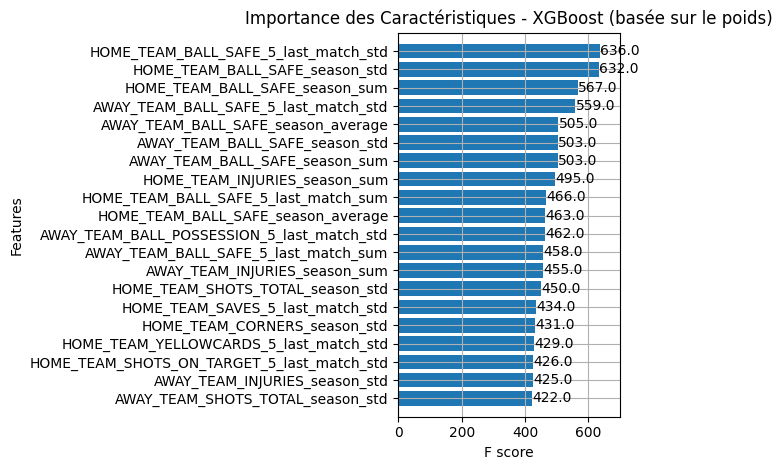

In [3]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 12, 
    'learning_rate': 0.1,
    'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss',
    }


d_train_away = xgb.DMatrix(X_train_away, label=y_train_away)
d_valid_away = xgb.DMatrix(X_valid_away, label=y_valid_away)

num_round = 50_000_000

evallist_away = [(d_train_away, 'train'), (d_valid_away, 'valid')]

bst_away = xgb.train(params_1, d_train_away, num_round, evallist_away, early_stopping_rounds=100, verbose_eval=1000)



plt.figure(figsize=(12, 8))
xgb.plot_importance(bst_away, max_num_features=20, height=0.8, importance_type='gain')
plt.title('Importance des Caractéristiques - XGBoost (basée sur le gain)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
xgb.plot_importance(bst_away, max_num_features=20, height=0.8, importance_type='weight')
plt.title('Importance des Caractéristiques - XGBoost (basée sur le poids)')
plt.tight_layout()
plt.show()

F1 Score: 0.6515

Rapport de classification:
              precision    recall  f1-score   support

           0       0.72      0.93      0.81      1703
           1       0.55      0.20      0.29       758

    accuracy                           0.70      2461
   macro avg       0.64      0.56      0.55      2461
weighted avg       0.67      0.70      0.65      2461


Matrice de confusion:
[[1584  119]
 [ 610  148]]


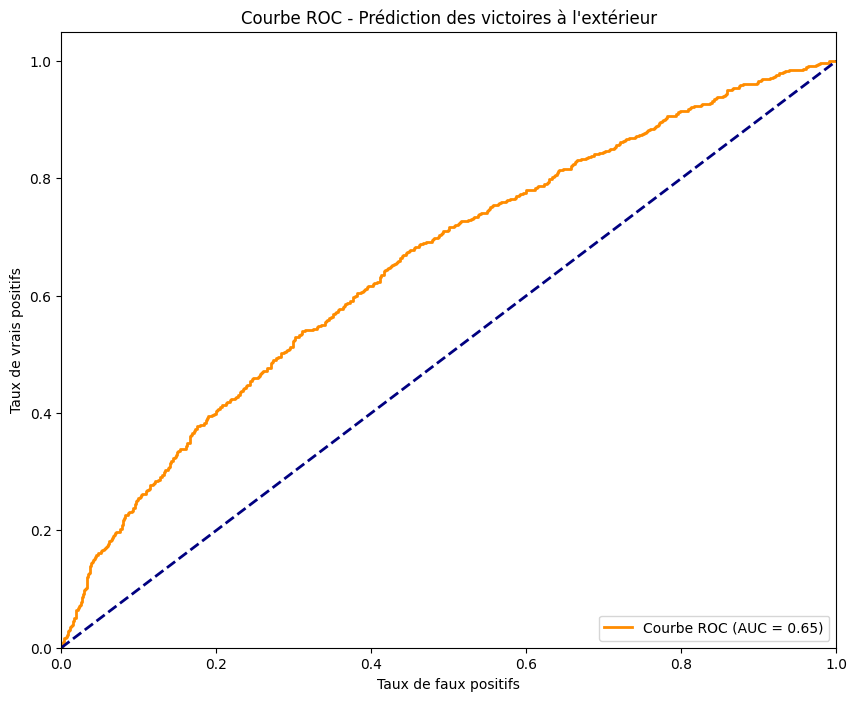

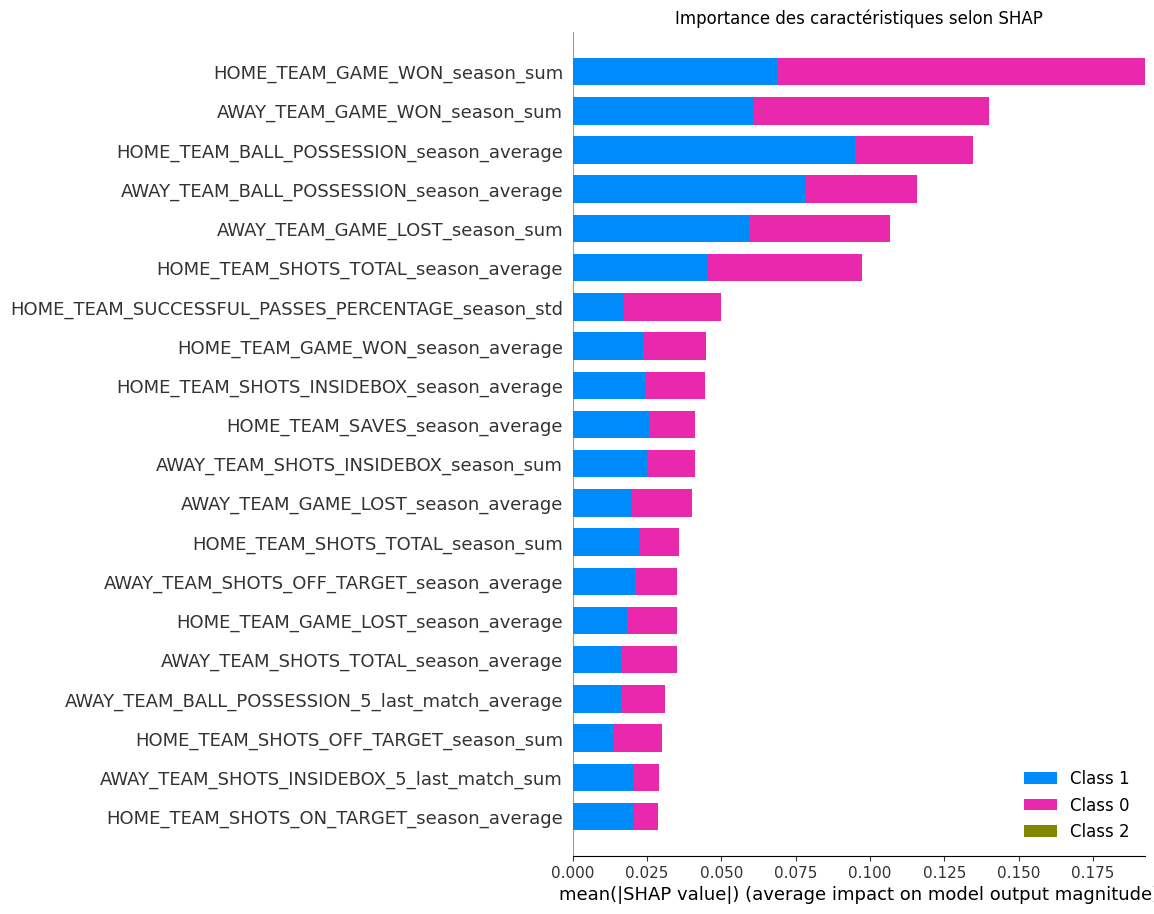

<Figure size 1500x1200 with 0 Axes>

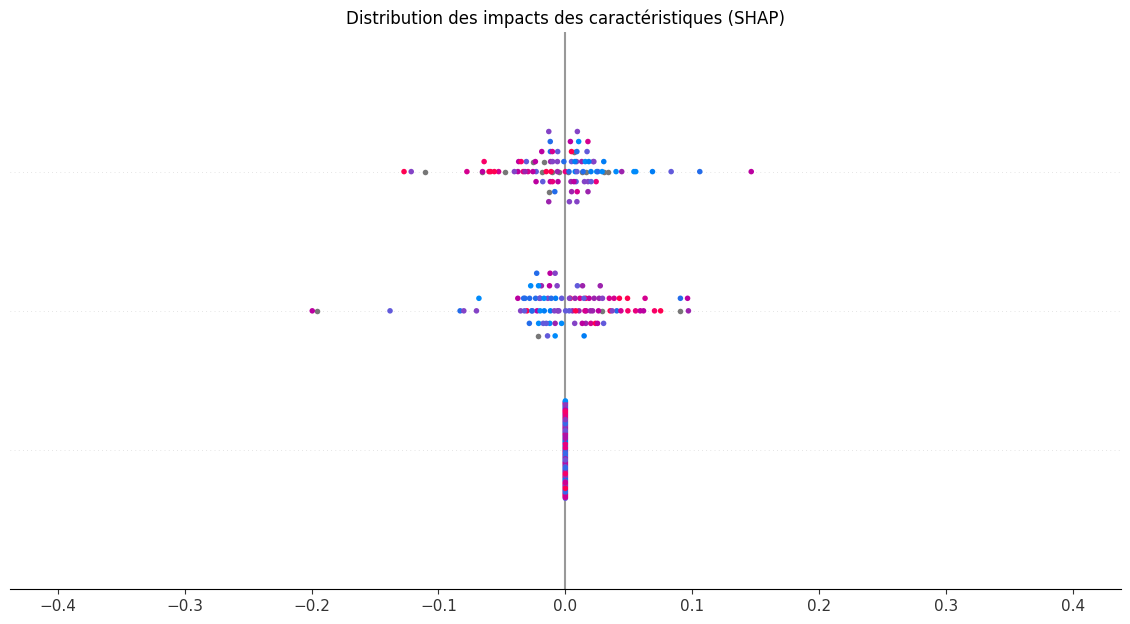

Top 20 caractéristiques les plus importantes selon SHAP:
                                               Feature  Importance
60                    HOME_TEAM_YELLOWCARDS_season_std    0.042981
100  HOME_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_...    0.033320
240  AWAY_TEAM_SUCCESSFUL_PASSES_PERCENTAGE_5_last_...    0.028210
200                   AWAY_TEAM_YELLOWCARDS_season_std    0.027782
61                       HOME_TEAM_REDCARDS_season_std    0.026529
201                      AWAY_TEAM_REDCARDS_season_std    0.022974
207             AWAY_TEAM_DANGEROUS_ATTACKS_season_std    0.021460
70              HOME_TEAM_SHOTS_TOTAL_5_last_match_sum    0.019841
69                          HOME_TEAM_GOALS_season_std    0.017331
206                     AWAY_TEAM_BALL_SAFE_season_std    0.015919
99    HOME_TEAM_SUCCESSFUL_PASSES_5_last_match_average    0.015625
1                 HOME_TEAM_SHOTS_INSIDEBOX_season_sum    0.014286
239   AWAY_TEAM_SUCCESSFUL_PASSES_5_last_match_average    0.014208
165  

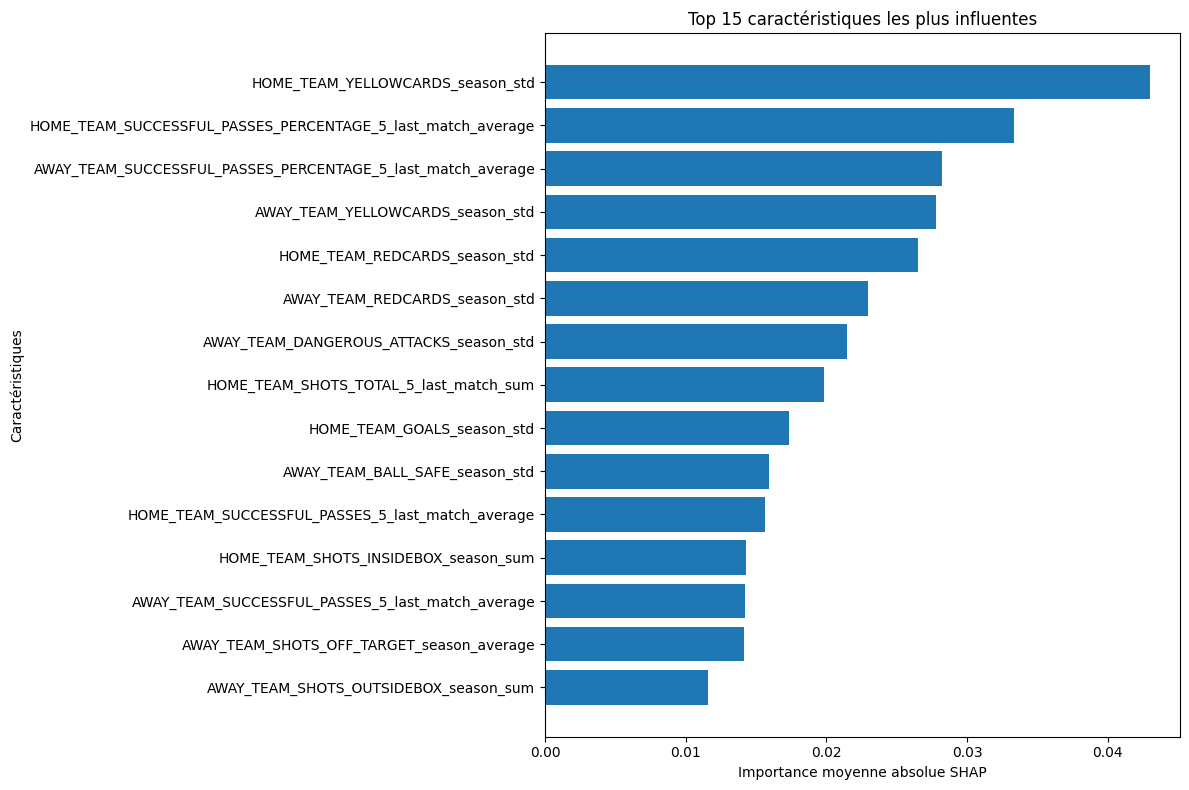

In [ ]:
# ROC Curve, F1 Score et caractéristiques importantes
from sklearn.metrics import roc_curve, auc, f1_score, classification_report, confusion_matrix

# Prédiction sur l'ensemble de test
d_test_away = xgb.DMatrix(X_test_away)
y_pred_proba = bst_away.predict(d_test_away)

# Convertir les prédictions en classes (cas multiclasse)
if len(y_pred_proba.shape) > 1:
    y_pred = np.argmax(y_pred_proba, axis=1)
    # Pour ROC: probabilité de la classe positive (victoire équipe visiteur)
    y_score = y_pred_proba[:, 1]
else:
    y_pred = (y_pred_proba > 0.5).astype(int)
    y_score = y_pred_proba

# Calcul du F1-score et autres métriques
f1 = f1_score(y_test_away, y_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Rapport de classification détaillé
print("\nRapport de classification:")
print(classification_report(y_test_away, y_pred))

print("\nMatrice de confusion:")
print(confusion_matrix(y_test_away, y_pred))

# Tracer la courbe ROC
fpr, tpr, _ = roc_curve(y_test_away, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC - Prédiction des victoires à l\'extérieur')
plt.legend(loc="lower right")
plt.show()


# Shap explainer
explainer = shap.TreeExplainer(bst_away)

sample_size = min(100, len(X_test_away)) # Echantillon de 100 car l'ensemble est grand
X_sample = X_test_away.iloc[:sample_size]


shap_values = explainer.shap_values(X_sample)

if isinstance(shap_values, list):
    shap_values = shap_values[1]  


plt.figure(figsize=(15, 12))
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=False)
plt.title("Importance des caractéristiques selon SHAP")
plt.tight_layout(pad=2.0)  
plt.gcf().subplots_adjust(left=0.25) 
plt.show()

# 2. Graphique NULL DE SHAP CAR ON VOIT PAS LES CARACTERISTIQUES
plt.figure(figsize=(15, 12))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title("Distribution des impacts des caractéristiques (SHAP)")
plt.tight_layout(pad=2.0)
plt.gcf().subplots_adjust(left=0.01) # MARGE A FOND
plt.show()

shap_values_2d = np.array(shap_values) if len(np.array(shap_values).shape) == 2 else np.array(shap_values).reshape(-1, len(X_sample.columns))

# SHAP caractéristiques 
top_features = pd.DataFrame({
    'Feature': X_sample.columns,
    'Importance': np.abs(shap_values_2d).mean(axis=0) 
}).sort_values('Importance', ascending=False).head(20)

print("Top 20 caractéristiques les plus importantes selon SHAP:")
print(top_features)

# TOP 15 CARACTERISTIQUES
top_15 = top_features.head(15)
plt.figure(figsize=(12, 8))
plt.barh(top_15['Feature'], top_15['Importance'])
plt.xlabel('Importance moyenne absolue SHAP')
plt.ylabel('Caractéristiques')
plt.title('Top 15 caractéristiques les plus influentes')
plt.gca().invert_yaxis()  # Pour que la plus importante soit en haut
plt.tight_layout()
plt.show()